<a href="https://colab.research.google.com/github/ph1-utkarsh/AI-Powered-Stock-Market-Forecasting-and-Algorithmic-Trading-System/blob/main/Stock_Prices_Prediction_Using_LSTM_and_ARIMA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Predicion Using LSTM:

In [2]:
goldman_data = yf.download('GS', start='2020-01-01', end='2024-06-01')

# Display the first few rows of the dataframe
goldman_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,231.000000,234.639999,230.160004,234.320007,209.588959,3736300
2020-01-03,231.600006,232.610001,230.300003,231.580002,207.138138,2274500
2020-01-06,229.929993,234.020004,229.490005,233.949997,209.258011,3329300
2020-01-07,235.000000,237.770004,234.759995,235.490005,210.635422,5255200
2020-01-08,235.679993,239.750000,235.479996,237.759995,212.665909,3564700


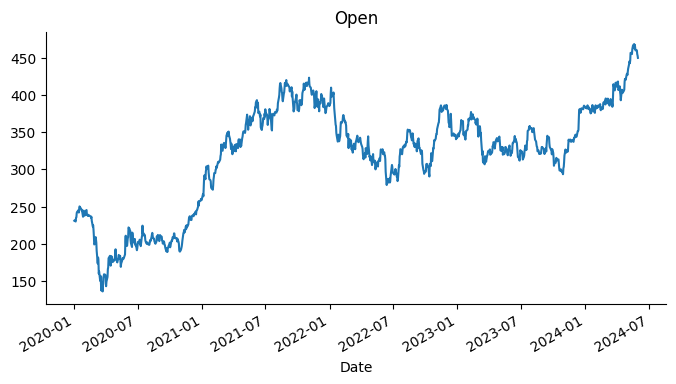

In [3]:
# @title Open

from matplotlib import pyplot as plt
goldman_data['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

In [4]:
# Checking for missing values
goldman_data.isnull().sum()

# Filling missing values, if any
goldman_data.fillna(method='ffill', inplace=True)

<ipython-input-4-96bccd13b175>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  goldman_data.fillna(method='ffill', inplace=True)


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
goldman_data_scaled = scaler.fit_transform(goldman_data['Close'].values.reshape(-1,1))

In [6]:
X = []
y = []

for i in range(60, len(goldman_data_scaled)):
    X.append(goldman_data_scaled[i-60:i, 0])
    y.append(goldman_data_scaled[i, 0])

In [7]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

In [10]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute (Permute)                    │ (None, 50, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ permute_1 (Permute)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           3,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1)                   │               4 │
│ (BatchNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,605 (131.27 KB)

 Trainable params: 33,603 (131.26 KB)

 Non-trainable params: 2 (8.00 B)

In [13]:
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)
from keras.callbacks import EarlyStopping

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.7450 - val_loss: 0.3427
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2531 - val_loss: 0.3118
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2039 - val_loss: 0.2826
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1961 - val_loss: 0.2519
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.1880 - val_loss: 0.2320
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.1625 - val_loss: 0.2106
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1413 - val_loss: 0.1897
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.1287 - val_loss: 0.1692
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.1142 - val_loss: 0.1524
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0935 - val_loss: 0.1392
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0833 - val_loss: 0.1247
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0126 - val_loss: 0.0017
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0141 - val_loss: 8.1991e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0120 - val_loss: 0.0017
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0118 - val_loss: 0.0019
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0139 - val_loss: 0.0032
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0122 - val_loss: 6.6540e-04
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0144 - val_loss: 0.0067
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0119 - val_loss: 6.4354e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0159 - val_loss: 6.7244e-04
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0125 - val_loss: 0.0012
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0087 - val_loss: 0.0104
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━

In [15]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0020
Test Loss:  0.004368263762444258


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Mean Absolute Error:  0.05198984581772036
Root Mean Square Error:  0.06609284326813607


In [17]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of
data = yf.download('GS', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Stock Prices for the next 4 days:  [481.8285, 485.4241, 486.4983, 487.17004]


In [18]:
predicted_prices

[481.8285, 485.4241, 486.4983, 487.17004]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 4.6 MB/s eta 0:00:00
                 Close
2024-08-10  481.828491
2024-08-11  485.424103
2024-08-12  486.498291
2024-08-13  487.170044


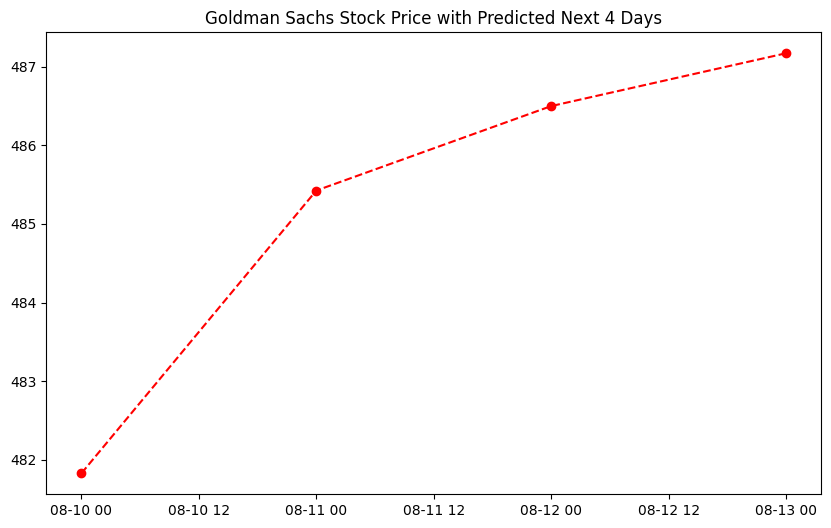

In [19]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])
print(predictions_df)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("Goldman Sachs Stock Price with Predicted Next 4 Days")
plt.show()

In [20]:
predictions_df

,Close
2024-08-10,481.828491
2024-08-11,485.424103
2024-08-12,486.498291
2024-08-13,487.170044


[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


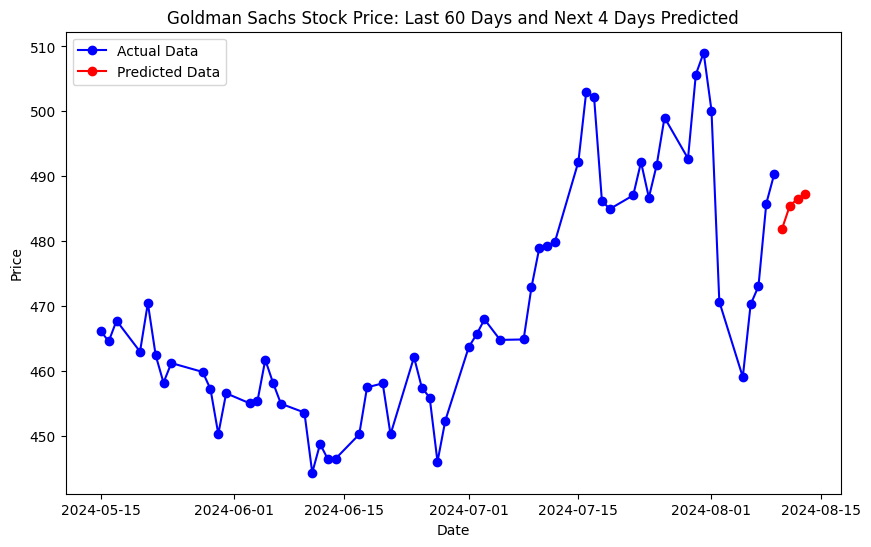

In [21]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('GS', period='3mo', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("Goldman Sachs Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [22]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

def predict_stock_price(input_date):
    # Check if the input date is a valid date format
    try:
        input_date = pd.to_datetime(input_date)
    except ValueError:
        print("Invalid Date Format. Please enter date in YYYY-MM-DD format.")
        return

    # Fetch data from yfinance
    end_date = input_date
    start_date = input_date - timedelta(days=90)  # Fetch more days to ensure we have 60 trading days
    data = yf.download('GS', start=start_date, end=end_date)

    if len(data) < 60:
        print("Not enough historical data to make a prediction. Try an earlier date.")
        return

    # Prepare the data
    closing_prices = data['Close'].values[-60:]  # Last 60 days
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

    # Make predictions
    predicted_prices = []
    current_batch = scaled_data.reshape(1, 60, 1)

    for i in range(4):  # Predicting 4 days
        next_prediction = model.predict(current_batch)
        next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
        current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
        predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

    # Output the predictions
    for i, price in enumerate(predicted_prices, 1):
        print(f"Day {i} prediction: {price}")

# Example use
user_input = input("Enter a date (YYYY-MM-DD) to predict Goldman Sachs stock for the next 4 days: ")
predict_stock_price(user_input)

Enter a date (YYYY-MM-DD) to predict Goldman Sachs stock for the next 4 days: 2024-08-12


[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Day 1 prediction: 481.8284912109375
Day 2 prediction: 485.4241027832031
Day 3 prediction: 486.498291015625
Day 4 prediction: 487.1700439453125


# Build and Train ARIMA Model

In [23]:
import yfinance as yf

# Download data
gs = yf.download("GS", start="2011-01-01", end="2024-07-01")

[*********************100%%**********************]  1 of 1 completed


In [24]:
import pandas as pd
# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

In [25]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.8 MB/s eta 0:00:00


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18953.961, Time=6.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18948.933, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18950.795, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18950.803, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18948.409, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18951.842, Time=8.69 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 17.758 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3394
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9473.204
Date:                Sat, 10 Aug 2024   AIC                          18948.409
Time:                        17:32:45   BIC                          18954.538
Sample:                             0   HQIC                         18950.600
   

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()

    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [ ]:
predictions

[391.20001220703125,
 406.07000732421875,
 413.69000244140625,
 412.1600036621094,
 407.8900146484375,
 407.5899963378906,
 414.32000732421875,
 414.75,
 417.6099853515625,
 410.989990234375,
 414.82000732421875,
 413.3500061035156,
 416.70001220703125,
 423.8500061035156,
 417.8999938964844,
 408.07000732421875,
 407.0799865722656,
 408.3399963378906,
 405.3500061035156,
 399.1199951171875,
 402.3399963378906,
 404.9100036621094,
 404.80999755859375,
 403.0899963378906,
 391.54998779296875,
 391.3699951171875,
 387.3900146484375,
 396.1600036621094,
 406.3399963378906,
 399.19000244140625,
 389.3900146484375,
 386.5400085449219,
 380.989990234375,
 376.4800109863281,
 387.5400085449219,
 382.7300109863281,
 389.29998779296875,
 400.1099853515625,
 397.32000732421875,
 396.489990234375,
 391.05999755859375,
 384.6400146484375,
 388.82000732421875,
 389.9100036621094,
 397.3699951171875,
 381.79998779296875,
 371.6099853515625,
 380.32000732421875,
 382.3299865722656,
 385.0400085449219

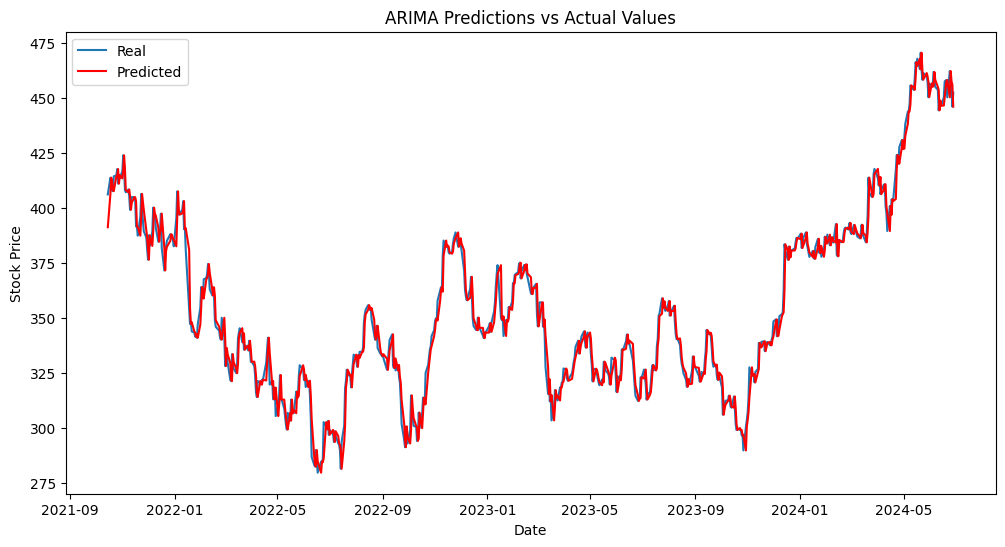

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [29]:
predictions

[391.20001220703125,
 406.07000732421875,
 413.69000244140625,
 412.1600036621094,
 407.8900146484375,
 407.5899963378906,
 414.32000732421875,
 414.75,
 417.6099853515625,
 410.989990234375,
 414.82000732421875,
 413.3500061035156,
 416.70001220703125,
 423.8500061035156,
 417.8999938964844,
 408.07000732421875,
 407.0799865722656,
 408.3399963378906,
 405.3500061035156,
 399.1199951171875,
 402.3399963378906,
 404.9100036621094,
 404.80999755859375,
 403.0899963378906,
 391.54998779296875,
 391.3699951171875,
 387.3900146484375,
 396.1600036621094,
 406.3399963378906,
 399.19000244140625,
 389.3900146484375,
 386.5400085449219,
 380.989990234375,
 376.4800109863281,
 387.5400085449219,
 382.7300109863281,
 389.29998779296875,
 400.1099853515625,
 397.32000732421875,
 396.489990234375,
 391.05999755859375,
 384.6400146484375,
 388.82000732421875,
 389.9100036621094,
 397.3699951171875,
 381.79998779296875,
 371.6099853515625,
 380.32000732421875,
 382.3299865722656,
 385.0400085449219

# Backtesting Logic Using Rolling Window Backtesting

In [30]:
# Fetch stock data
df = yf.download('GS', start='2011-01-01', end='2024-07-01')
df = df[['Close']]
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

lookback = 60
X, y = create_dataset(scaled_data, lookback)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(lookback, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=40, validation_data=(X_test, y_test))

# Make LSTM predictions
lstmpredictions = model.predict(X_test)
lstmpredictions = scaler.inverse_transform(lstmpredictions)


[*********************100%%**********************]  1 of 1 completed

Epoch 1/100



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0267 - val_loss: 0.0036
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 5.2833e-04 - val_loss: 0.0016
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.3150e-04 - val_loss: 0.0017
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 4.5006e-04 - val_loss: 0.0013
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 4.3031e-04 - val_loss: 0.0016
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 4.4484e-04 - val_loss: 0.0012
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 3.6208e-04 - val_loss: 0.0010
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 3.4193e-04 - val_loss: 0.0013
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 3.5392e-04 - val_loss: 9.3062e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 2.8329e-04 - val_loss: 0.0012
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 2.8506e-04 - val_loss: 8.1606e-04
Epoch 12/100
67/

In [31]:
lstmpredictions

array([[416.00876],
       [420.00067],
       [427.88632],
       [418.33322],
       [408.14682],
       [410.62897],
       [412.57675],
       [407.89352],
       [400.84235],
       [406.61304],
       [408.90878],
       [407.46396],
       [405.38745],
       [392.06464],
       [395.16248],
       [390.89633],
       [401.73746],
       [411.6755 ],
       [399.4899 ],
       [389.53952],
       [389.89862],
       [384.24722],
       [379.64886],
       [393.95456],
       [385.22235],
       [393.17844],
       [405.37527],
       [398.76114],
       [398.35355],
       [392.99252],
       [386.7919 ],
       [393.7513 ],
       [393.97205],
       [401.8691 ],
       [381.07007],
       [372.44516],
       [386.81924],
       [386.99698],
       [388.26306],
       [391.31442],
       [390.11044],
       [388.606  ],
       [388.4807 ],
       [385.23495],
       [401.33862],
       [412.82565],
       [397.9858 ],
       [398.5273 ],
       [401.13486],
       [402.81348],


In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming predictions (ARIMA predictions) and y_pred (LSTM predictions) are already defined
# Ensure both predictions have the same length
min_length = min(len(predictions), len(lstmpredictions), len(test))

# Adjust the lengths of all arrays to the minimum length
predictions = np.array(predictions[:min_length])
y_pred = np.array(lstmpredictions[:min_length])
test = np.array(test[:min_length])

# Assuming `test_index` holds the indices corresponding to the test set
test_index = df.index[train_size:train_size + min_length]

# Create a DataFrame to hold the predictions
predictions_ens = pd.DataFrame({
    'ARIMA': predictions,
    'LSTM': y_pred.flatten() # Ensure y_pred is flattened if it's in a different shape
})

# Ensemble method: simple average of ARIMA and LSTM predictions
predictions_ens['Ensemble'] = predictions_ens.mean(axis=1)

In [33]:
predictions_ens

,ARIMA,LSTM,Ensemble
0,391.200012,416.008759,403.604385
1,406.070007,420.000671,413.035339
2,413.690002,427.886322,420.788162
3,412.160004,418.333221,415.246613
4,407.890015,408.146820,408.018417
...,...,...,...
662,455.299988,459.270447,457.285217
663,461.679993,449.676697,455.678345
664,458.100006,467.548279,462.824142
665,454.910004,457.832397,456.371201


In [40]:
print(f' Length of ensemble predictions: {len(predictions_ens)} ')
print(f' Length of test: {len(test)}')

 Length of ensemble predictions: 667 
 Length of test: 667


In [44]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Calculate R-squared
r2_arima = r2_score(test, predictions)
r2_lstm = r2_score(test, lstmpredictions)
r2_ens = r2_score(test, predictions_ens['Ensemble'])

# Display results
print(f"ARIMA Model  R²: {r2_arima}")
print(f"LSTM Model  R²: {r2_lstm}")
print(f"Ensemble Model  R²: {r2_ens}")


ARIMA Model  R²: 0.9796287389847355
LSTM Model  R²: 0.7428272236688993
Ensemble Model  R²: 0.9310769101596071


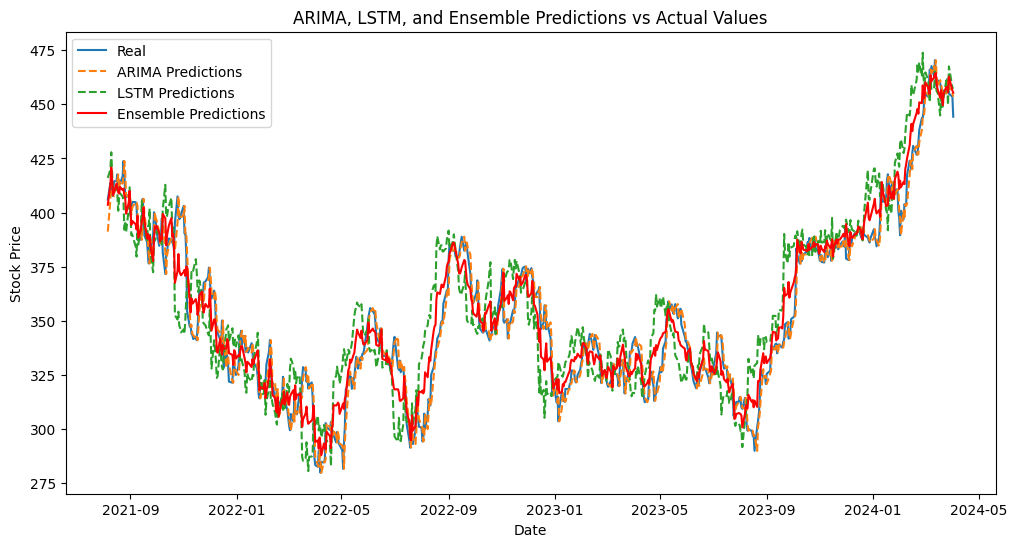

In [34]:
# Ensemble method: simple average of ARIMA and LSTM predictions
predictions_ens['Ensemble'] = predictions_ens.mean(axis=1)

# Plot the results
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_index, test, label='Real')
plt.plot(test_index, predictions_ens['ARIMA'], label='ARIMA Predictions', linestyle='--')
plt.plot(test_index, predictions_ens['LSTM'], label='LSTM Predictions', linestyle='--')
plt.plot(test_index, predictions_ens['Ensemble'], color='red', label='Ensemble Predictions')
plt.title('ARIMA, LSTM, and Ensemble Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [52]:
test_arima = predictions.iloc[i]
test_arima

,12
predictions,416.700012


In [61]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define window size and step size
window_size = 12  # Example: 12 months
step_size = 1  # Step by 1 month

# Initialize lists to store results
results_arima = []
results_lstm = []
results_ens = []

# Convert NumPy arrays to Pandas DataFrames if necessary
if isinstance(predictions, np.ndarray):
    predictions = pd.DataFrame(predictions, columns=['predictions'])
if isinstance(lstmpredictions, np.ndarray):
    lstmpredictions = pd.DataFrame(lstmpredictions, columns=['lstmpredictions'])
if isinstance(predictions_ens, np.ndarray):
    predictions_ens = pd.DataFrame(predictions_ens, columns=['Ensemble'])

# Get the date range for backtesting
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')  # Updated to include 2023

# Assuming you have actual values for this period, generate the dates
# Replace this with your actual data
actual_values = np.random.rand(len(predictions))  # Dummy actuals for illustration

dates = pd.date_range(start=start_date, end=end_date, periods=len(actual_values))

# Creating the actuals dataframe
actuals_df = pd.DataFrame({'date': dates, 'actuals': actual_values.flatten()})

# Assuming predictions, lstmpredictions, and predictions_ens dataframes don't have a 'date' column, add it
predictions['date'] = dates
lstmpredictions['date'] = dates
predictions_ens['date'] = dates

# Perform Rolling Window Backtesting
for i in range(window_size, len(predictions), step_size):

    # Define the training window
    train_arima = predictions.iloc[i-window_size:i]
    train_lstm = lstmpredictions.iloc[i-window_size:i]
    train_ens = predictions_ens.iloc[i-window_size:i]

    # Define the test point (next time step)
    test_arima = predictions.iloc[i]
    test_lstm = lstmpredictions.iloc[i]
    test_ens = predictions_ens.iloc[i]

    # Get the actual value for the test point from the actuals_df
    actual_test = actuals_df.loc[actuals_df['date'] == test_arima['date'], 'actuals'].values[0]

    # Evaluate performance on the test point
    mae_arima = mean_absolute_error([actual_test], [test_arima['predictions']])
    mae_lstm = mean_absolute_error([actual_test], [test_lstm['lstmpredictions']])
    mae_ens = mean_absolute_error([actual_test], [test_ens['Ensemble']])

    mse_arima = mean_squared_error([actual_test], [test_arima['predictions']])
    mse_lstm = mean_squared_error([actual_test], [test_lstm['lstmpredictions']])
    mse_ens = mean_squared_error([actual_test], [test_ens['Ensemble']])

    rmse_arima = np.sqrt(mse_arima)
    rmse_lstm = np.sqrt(mse_lstm)
    rmse_ens = np.sqrt(mse_ens)

    # Store results
    results_arima.append({'date': test_arima['date'], 'mae': mae_arima, 'rmse': rmse_arima})
    results_lstm.append({'date': test_lstm['date'], 'mae': mae_lstm, 'rmse': rmse_lstm})
    results_ens.append({'date': test_ens['date'], 'mae': mae_ens, 'rmse': rmse_ens})

# Convert results to DataFrames for analysis
results_arima_df = pd.DataFrame(results_arima)
results_lstm_df = pd.DataFrame(results_lstm)
results_ens_df = pd.DataFrame(results_ens)

# Display the results
print("ARIMA Rolling Window Results:")
print(results_arima_df.head())

print("\nLSTM Rolling Window Results:")
print(results_lstm_df.head())

print("\nEnsemble Rolling Window Results:")
print(results_ens_df.head())


ARIMA Rolling Window Results:
                           date         mae        rmse
0 2023-01-07 13:24:19.459459459  415.728226  415.728226
1 2023-01-08 02:31:21.081081081  423.036172  423.036172
2 2023-01-08 15:38:22.702702702  417.446710  417.446710
3 2023-01-09 04:45:24.324324324  408.044553  408.044553
4 2023-01-09 17:52:25.945945946  406.751436  406.751436

LSTM Rolling Window Results:
                           date         mae        rmse
0 2023-01-07 13:24:19.459459459  404.415665  404.415665
1 2023-01-08 02:31:21.081081081  391.250802  391.250802
2 2023-01-08 15:38:22.702702702  394.709192  394.709192
3 2023-01-09 04:45:24.324324324  390.870877  390.870877
4 2023-01-09 17:52:25.945945946  401.408906  401.408906

Ensemble Rolling Window Results:
                           date         mae        rmse
0 2023-01-07 13:24:19.459459459  410.071945  410.071945
1 2023-01-08 02:31:21.081081081  407.143487  407.143487
2 2023-01-08 15:38:22.702702702  406.077951  406.077951
3 2023-01-